In [1]:
import xarray as xr
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# location of 10-min timeseries of surge
sys.path.append("..")
from path_dict import path_dict
dir_postproc = path_dict['postproc']
dir_ts = os.path.join(dir_postproc,'timeseries-GTSM-ERA5-10min','surge')
dir_ts2 = os.path.join(dir_postproc,'timeseries-GTSM-ERA5-10min-1979-2018','surge')

In [3]:
# output directory
outdir = os.path.join(dir_postproc,'SeaLevelMonitor')

In [4]:
# select year to process
yrs = range(2024,2025)

In [5]:
for yr in yrs:
    print(f'Processing year {yr}...')

    if yr in range(1980,2019):
        dir_ts_yr = dir_ts2
    else:
        dir_ts_yr = dir_ts
    ts_files = glob.glob(os.path.join(dir_ts_yr,f'reanalysis_surge_10min_{yr}_*_v1.nc'))

    if len(ts_files) == 12:
        # open all data for that year in one dataset
        ds = xr.open_mfdataset(ts_files)
        
        # resample to monthly means
        ds_monthly_mean = ds.resample(time='M',label='right').mean()

        # remove duplicate coordinate data
        ds_monthly_mean['station_x_coordinate'] = ds_monthly_mean['station_x_coordinate'].isel(time=0,drop=True)
        ds_monthly_mean['station_y_coordinate'] = ds_monthly_mean['station_y_coordinate'].isel(time=0,drop=True) 
        
        # create coordinate with year and month numbers
        year = ds_monthly_mean.time.dt.year
        month = ds_monthly_mean.time.dt.month
        ds_monthly_mean = ds_monthly_mean.assign_coords(year=("time", year.data), month=("time", month.data))
        
        # reshape the array to (..., "month", "year")
        ds_monthly_mean = ds_monthly_mean.set_index(time=("year", "month")).unstack("time")

        # decode station name strings
        #ds_monthly_mean['station_name'] = ds_monthly_mean['station_name'].load().str.decode('utf-8',errors='ignore').str.strip()

        # drop the time dimension on coordinates that got added when opening the dataset
        ds_monthly_mean.load()
        ds_monthly_mean = ds_monthly_mean.set_coords(("station_y_coordinate", "station_x_coordinate"))
        
        # save resulting file
        ofile = os.path.join(outdir,'era5_reanalysis_surge_%s_v1_monthly_mean.nc' % yr)
        ds_monthly_mean.to_netcdf(ofile)
        #del ds, ds_monthly_mean
        print('==== Done!')
    else:
        print('==== Not all months are available in %s'% yr)


Processing year 2024...
==== Done!


In [6]:
ds_monthly_mean

<xarray.Dataset>
Dimensions:               (year: 1, month: 12, stations: 43119)
Coordinates:
  * year                  (year) int64 2024
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    station_x_coordinate  (stations) float64 24.09 24.09 26.9 ... 37.75 37.95
    station_y_coordinate  (stations) float64 34.83 34.87 35.37 ... -46.98 -46.63
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    surge                 (stations, year, month) float32 -0.02466 ... 0.06585
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         10-minute timeseries of surge levels
    ...                            ...
    geospatial_vertical_max:       2.558
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2024-01-01 00:00:00
    time_coverage_end:             2024-01-31 23:50:00
    experiment:                    reanalysis

In [7]:
# Get station names (no longer saved by default after 2023)
ds_2023 = xr.open_dataset(os.path.join(outdir,'era5_reanalysis_surge_%s_v1_monthly_mean.nc' % 2023))
ds_2023

<xarray.Dataset>
Dimensions:               (year: 1, month: 12, stations: 43119)
Coordinates:
  * year                  (year) int64 2023
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
    station_name          (stations) object ...
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    surge                 (stations, year, month) float32 ...
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         10-minute timeseries of surge levels
    ...                            ...
    geospatial_vertical_max:       2.497
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2023-01-01 00:00:00
    time_coverage_end:             2023-01-31 23:50:00
    experiment:                    reanalysis

In [8]:
# Assign station names 
ds_monthly_mean['station_name'] = ds_2023['station_name']
ds_monthly_mean = ds_monthly_mean.set_coords(('station_name'))

# Save the new dataset of monthly means including the station names
ds_monthly_mean.to_netcdf(ofile)

ds_monthly_mean

<xarray.Dataset>
Dimensions:               (year: 1, month: 12, stations: 43119)
Coordinates:
  * year                  (year) int64 2024
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    station_x_coordinate  (stations) float64 24.09 24.09 26.9 ... 37.75 37.95
    station_y_coordinate  (stations) float64 34.83 34.87 35.37 ... -46.98 -46.63
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
    station_name          (stations) object ...
Data variables:
    surge                 (stations, year, month) float32 -0.02466 ... 0.06585
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         10-minute timeseries of surge levels
    ...                            ...
    geospatial_vertical_max:       2.558
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2024-01-01 00:00:00
    time_coverage_end:             2024-01-31 23:50:00
    experiment:                    reanalysis

In [9]:
# checkplot of timeseries and monthly means for one location

loc = [4.556043, 52.461978] # IJmuiden station coordinates [lon,lat]

# find station number
abslon = np.abs(ds_monthly_mean.station_x_coordinate-loc[0])
abslat = np.abs(ds_monthly_mean.station_y_coordinate-loc[1])
station_id = ds_monthly_mean['stations'].isel(stations=np.argmin(abslon.values**2 + abslat.values**2)).values.tolist()

In [10]:
ds_monthly_mean['surge'].sel(stations=station_id)

<xarray.DataArray 'surge' (year: 1, month: 12)>
array([[ 0.13338467,  0.1651719 ,  0.05322402,  0.12549256, -0.01523426,
         0.04895468,  0.0652408 ,  0.04794333,  0.02573166,  0.02390991,
         0.07186969,  0.05579389]], dtype=float32)
Coordinates:
  * year                  (year) int64 2024
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    station_x_coordinate  float64 4.548
    station_y_coordinate  float64 52.46
    stations              uint16 39600
    station_name          object ...
Attributes:
    long_name:    storm_surge
    units:        m
    short_name:   storm_surge
    description:  Surge signal resulting from subtracting water level and tid...
    coordinates:  station_x_coordinate station_y_coordinate station_name

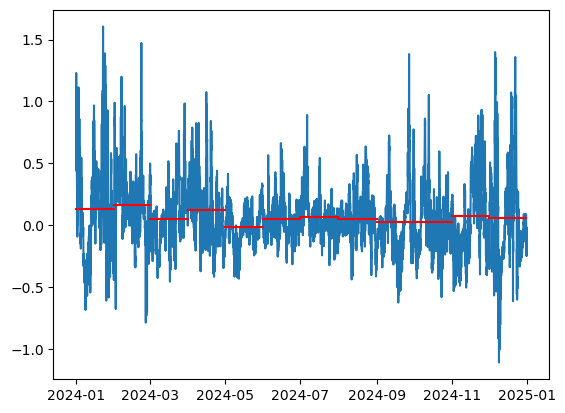

In [37]:
# Make a plot of timeseries and monthly means
plt.plot(ds['time'],ds['surge'].sel(stations=station_id))
for mm in range(0,12):
    time1 = np.datetime64(f"{ds_monthly_mean['year'].values[0]}-{ds_monthly_mean['month'][mm].values:02}")
    if mm==11:
        time2 = np.datetime64(f"{ds_monthly_mean['year'].values[0]}-{ds_monthly_mean['month'][mm].values:02}-31")
    else:
        time2 = np.datetime64(f"{ds_monthly_mean['year'].values[0]}-{ds_monthly_mean['month'][mm+1].values:02}")
    plt.plot([time1,time2],[ds_monthly_mean['surge'].sel(stations=station_id).squeeze().values[mm],ds_monthly_mean['surge'].sel(stations=station_id).squeeze().values[mm]],color='red')
    

In [39]:
# Plot all means
files = glob.glob(os.path.join(outdir,'era5_reanalysis_surge_*_v1_monthly_mean.nc'))
ds_all = xr.open_mfdataset(files)


In [40]:
ds_all

<xarray.Dataset>
Dimensions:               (year: 36, month: 12, stations: 43119)
Coordinates:
  * year                  (year) int64 1950 1951 1952 1953 ... 2022 2023 2024
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    station_x_coordinate  (year, stations) float64 24.09 24.09 ... 37.75 37.95
    station_y_coordinate  (year, stations) float64 34.83 34.87 ... -46.98 -46.63
    station_name          (stations) object dask.array<chunksize=(43119,), meta=np.ndarray>
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    surge                 (stations, year, month) float32 dask.array<chunksize=(43119, 1, 12), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_surge
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         10-minute timeseries of surge levels
    ...                            ...
    geospatial_vertical_max:       5.61
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           1950-01-01 00:00:00
    time_coverage_end:             1950-01-31 23:50:00
    experiment:                    reanalysis

In [42]:
ds_all.month.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Text(0.5, 1.0, 'Mean monthly surge at NWS_NO_TS_MO_Ijmuiden \n for each year in 1950-2024')

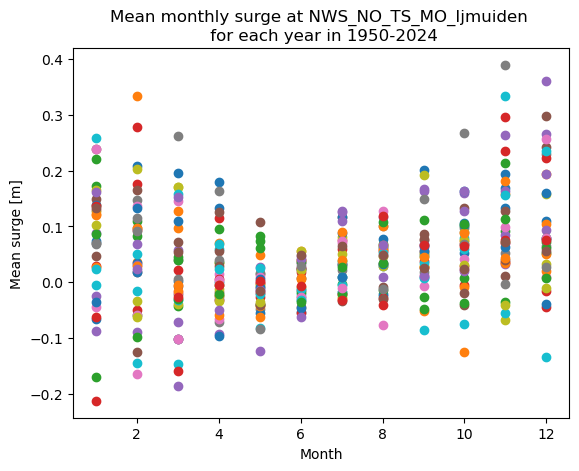

In [52]:
fig,ax = plt.subplots()
for yy in ds_all.year.values:
    plt.scatter(ds_all.month.values,ds_all['surge'].sel(year=yy).sel(stations=station_id).values)
ax.set_xlabel('Month')
ax.set_ylabel('Mean surge [m]')
ax.set_title(f'Mean monthly surge at {ds_all.sel(stations=station_id).station_name.values} \n for each year in {ds_all["year"].values[0]}-{ds_all["year"].values[-1]}')